# Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [93]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from pathlib import Path
import warnings
import pickle
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils.coco import COCODataset
from src.utils.pretty_print import *
from src.models import get_model_resnet34, get_model_unet, get_model_maskrcnn_with_groupnorm
from src.utils.eval import resnet_eval, unet_eval, maskrcnn_eval
from src.utils.visualization import visualize_masks

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 42

# for reproducibility
torch.manual_seed(SEED)

# Datasets

## Slide dataset

In [24]:
slide_path = Path("/storage01/bolma/dev/data/datasets/WSI-ROI/slides/l8/annotations.json")

In [25]:
slide_dataset = COCODataset(
    annotation_file=slide_path,
    train=False,
    transform=None,
    random_seed=SEED,
    split_file=Path("dataset_split.json"),
    bbox_format='pascal_voc'
)

print_success("Datasets is ready to use!")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

✅ Loaded split from dataset_split.json

✅ Found 38 training images and 10 test images

✅ Loaded test set with 10 images


✅ Datasets is ready to use!


In [46]:
BATCH_SIZE = 1
NUM_WORKERS = 8

In [47]:
slide_dataloader = DataLoader(
    slide_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    #collate_fn=lambda x: tuple(zip(*x))
)

print_info(f"Created DataLoader with batch size {BATCH_SIZE}")
print(f"\t- Test batches: {len(slide_dataloader)}")


ℹ️ Created DataLoader with batch size 1
	- Test batches: 10


## Tile dataset

In [3]:
tile_path = Path("/storage01/bolma/dev/data/datasets/WSI-ROI/tiles/l6_256x256_tiles.json")

In [4]:
tile_dataset = COCODataset(
    annotation_file=tile_path,
    train=False,
    transform=None,
    random_seed=SEED,
    split_file=Path("dataset_split.json"),
    bbox_format='pascal_voc'
)

print_success("Datasets is ready to use!")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded split from dataset_split.json

✅ Found 4423 training images and 1211 test images

✅ Loaded test set with 1211 images


✅ Datasets is ready to use!


In [5]:
BATCH_SIZE = 32
NUM_WORKERS = 8

In [6]:
def classification_collate_fn(batch):
    """
    Custom collate function for to properly handle batching for classification tasks.
    """
    images = []
    labels = []
    
    for sample in batch:
        image, target = sample
        images.append(image)
        
        # For classification, we only need the label
        # Assuming the first label is the class we want to predict
        if 'labels' in target and len(target['labels']) > 0:
            labels.append(target['labels'][0])
        else:
            # Default to class 0 if no label is present
            labels.append(torch.tensor(0))
    
    # Stack images and labels into batches
    images = torch.stack(images, 0)
    labels = torch.stack(labels, 0)
    
    return images, {'labels': labels}

In [7]:
tile_dataloader = DataLoader(
    tile_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=classification_collate_fn
)

print_info(f"Created DataLoader with batch size {BATCH_SIZE}")
print(f"\t- Test batches: {len(tile_dataloader)}")


ℹ️ Created DataLoader with batch size 32
	- Test batches: 38


# Evaluation

## Tile-based

In [8]:
resnet = get_model_resnet34(num_classes=2, pretrained=True)

optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)

Using cache found in /home/bolma/.cache/torch/hub/pytorch_vision_v0.10.0


In [9]:
resnet.load_state_dict(torch.load("src/models/weights/ResNet_trained_weights_eval.pth", weights_only=True))
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [154]:
resnet_results = resnet_eval(model=resnet,device=device, eval_dataset_annotation_path=tile_path)

results_path = Path("results/resnet_results.pkl")
    
with open(results_path, 'wb') as f:
    pickle.dump(resnet_results, f)
print_success(f"Results saved to {results_path}")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

✅ Loaded split from /storage01/bolma/dev/tumor-region-detection-thesis/dataset_split.json

✅ Found 4423 training images and 1211 test images

✅ Loaded test set with 1211 images



Processing images: 100%|██████████| 1211/1211 [00:05<00:00, 222.30it/s]


Found 10 unique WSI sources.


Creating masks from tile groups: 100%|██████████| 10/10 [00:00<00:00, 386.97it/s]



✅ Results saved to results/resnet_results.pkl


In [41]:
print(f"Mean IoU = {np.average(np.array(resnet_results['ious'])):.4f}, Mean inference time = {np.average(np.array(resnet_results['inference_times'])):.4f} s")

Mean IoU = 0.4954, Mean inference time = 2.7725 s


## Semantic segmentation

In [43]:
unet = get_model_unet(in_channels=3,
                          out_channels=1,
                          features=[32, 64, 128, 256])

In [44]:
unet.load_state_dict(torch.load("src/models/weights/UNet_trained_weights_eval.pth", weights_only=True))
unet.eval()

UNet(
  (ups): ModuleList(
    (0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pad

In [48]:
# Supressing some warning coming from a library with legacy code
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Creating a tensor from a list of numpy.ndarrays is extremely slow.')
    unet_results = unet_eval(
        model=unet,
        device=device,
        dataloader=slide_dataloader,
)
    
results_path = Path("results/unet_results.pkl")
    
with open(results_path, 'wb') as f:
    pickle.dump(unet_results, f)
print_success(f"Results saved to {results_path}")

10it [00:01,  9.58it/s]



✅ Results saved to results/unet_results.pkl


In [49]:
print(f"Mean IoU = {np.average(np.array(unet_results['ious'])):.4f}, Mean inference time = {np.average(np.array(unet_results['inference_times'])):.4f} s")

Mean IoU = 0.4837, Mean inference time = 0.0214 s


## Instance segmentation

In [50]:
maskrcnn = get_model_maskrcnn_with_groupnorm(num_classes=2, 
                      box_score_thresh=0.1,
                      box_nms_thresh=0.3,
                      box_fg_iou_thresh=0.5,
                      box_bg_iou_thresh=0.4,
                      box_detections_per_img=10,
                      image_mean = [0.485, 0.456, 0.406],
                      image_std = [0.229, 0.224, 0.225])

In [51]:
maskrcnn.load_state_dict(torch.load("src/models/weights/MaskRCNN_trained_weights_eval.pth", weights_only=True))
maskrcnn.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): GroupNorm(32, 256, eps=1

In [157]:
# Supressing some warning coming from a library with legacy code
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Creating a tensor from a list of numpy.ndarrays is extremely slow.')
    maskrcnn_results = maskrcnn_eval(
        model=maskrcnn,
        device=device,
        dataloader=slide_dataloader,
)
    
results_path = Path("results/maskrcnn_results.pkl")
    
with open(results_path, 'wb') as f:
    pickle.dump(maskrcnn_results, f)
print_success(f"Results saved to {results_path}")

10it [00:01,  9.45it/s]


✅ Results saved to results/maskrcnn_results.pkl


In [53]:
print(f"Mean IoU = {np.average(np.array(maskrcnn_results['ious'])):.4f}, Mean inference time = {np.average(np.array(maskrcnn_results['inference_times'])):.4f} s")

Mean IoU = 0.4539, Mean inference time = 0.0868 s


# Afterwork

## Matching batch indices with WSI names for model comparison

In [54]:
def map_indices_to_wsi_names(slide_dataset):
    """Maps dataloader batch indices to WSI filenames/identifiers"""
    index_to_wsi_map = {}
    
    # Iterate through dataset using its indices
    for idx in range(len(slide_dataset)):
        # Get the image info - accessing the internal COCO dataset
        img_id = slide_dataset.image_ids[idx]
        img_info = slide_dataset.coco.loadImgs(img_id)[0]
        
        # Extract filename from the image path
        file_path = img_info['file_name']
        wsi_name = str(Path(file_path).stem).split("_lvl")[0]
        
        # Create mapping from index to WSI name
        index_to_wsi_map[idx] = wsi_name
    
    return index_to_wsi_map

index_to_wsi_map = map_indices_to_wsi_names(slide_dataset)

print(index_to_wsi_map)

{0: '8394_24_A4', 1: '1170_17_HE_40x', 2: '779-21_a2_HE_20230308_8', 3: '6766_21_A3_HE_20240515', 4: '290_23_A3_HE_20240116_1', 5: '109_17_HE_40x', 6: '92_17_HE_40x', 7: '5003_11_HE_40x', 8: '995_18_HE_40x', 9: '3201_17_HE_40x'}


In [ ]:
matched_results = {
    'method': [],
    'wsi_name': [],
    'iou': [],
    'inference_time': [],
    'prediction': [],
}

# ResNet results
for i, wsi_name in enumerate(resnet_results['indices']):
    matched_results['method'].append('Tile-based')
    matched_results['wsi_name'].append(wsi_name)
    matched_results['iou'].append(resnet_results['ious'][i])
    matched_results['inference_time'].append(resnet_results['inference_times'][i])
    matched_results['prediction'].append(resnet_results['predictions'][i])
# UNet results
for i, idx in enumerate(unet_results['indices']):
    if idx in index_to_wsi_map:
        matched_results['method'].append('Semantic segmentation')
        matched_results['wsi_name'].append(index_to_wsi_map[idx])
        matched_results['iou'].append(unet_results['ious'][i])
        matched_results['inference_time'].append(unet_results['inference_times'][i])
        matched_results['prediction'].append(unet_results['predictions'][i])
    else:
        raise ValueError(f"Index {idx} not found in index_to_wsi_map.")
# Mask R-CNN
for i, idx in enumerate(maskrcnn_results['indices']):
    if idx in index_to_wsi_map:
        matched_results['method'].append('Instance segmentation')
        matched_results['wsi_name'].append(index_to_wsi_map[idx])
        matched_results['iou'].append(maskrcnn_results['ious'][i])
        matched_results['inference_time'].append(maskrcnn_results['inference_times'][i])
        matched_results['prediction'].append(maskrcnn_results['predictions'][i])
    else:
        raise ValueError(f"Index {idx} not found in index_to_wsi_map.")
    
# Save the matched results to a pickle file
results_path = Path("results/matched_results.pkl")
with open(results_path, 'wb') as f:
    pickle.dump(matched_results, f)
print_success(f"Results saved to {results_path}")


✅ Results saved to results/matched_results.pkl


# Results

## Loading pickled data (no need to rerun the whole eval process)

In [115]:
with open('results/matched_results.pkl', 'rb') as f:
    results = pickle.load(f)

print_success("All results loaded successfully!")


✅ All results loaded successfully!


## Results printing

### Raw print

In [76]:
# Load matched results
with open('results/matched_results.pkl', 'rb') as f:
    matched_results = pickle.load(f)
# print order
print_order = ["Tile-based", "Semantic segmentation", "Instance segmentation"]

# Create DataFrame from matched results
results_df = pd.DataFrame({
    'method': matched_results['method'],
    'wsi_name': matched_results['wsi_name'],
    'iou': [float(iou) for iou in matched_results['iou']],
    'inference_time': [float(time) for time in matched_results['inference_time']]
})

# reorder the methods based on the print order
results_df['method'] = pd.Categorical(
    results_df['method'], 
    categories=print_order,
    ordered=True
)

# statistics by methods
print("Statistics by Methods")
print("=" * 60)
print("IoU")
method_stats = results_df.groupby('method', observed=False).agg({
    'iou': ['mean', 'std', 'min', 'max'],
}).round(4)
display(method_stats)

print("Inference time")
method_stats = results_df.groupby('method', observed=False).agg({
    'inference_time': ['mean', 'std', 'min', 'max'],
}).round(4)
display(method_stats)



# Individual WSI results
print("Results by WSI")
print("=" * 60)
pivot_df = results_df.pivot_table(
    index='wsi_name', 
    columns='method', 
    values=['iou', 'inference_time'],
    aggfunc='mean',
    observed=False
).round(4)
display(pivot_df)

Statistics by Methods
IoU


iou                        
                         mean     std     min     max
method                                               
Tile-based             0.4954  0.2397  0.0000  0.7419
Semantic segmentation  0.4837  0.2739  0.0000  0.7887
Instance segmentation  0.4539  0.1351  0.2807  0.6997

Inference time


inference_time                        
                                mean     std     min     max
method                                                      
Tile-based                    2.8197  0.1452  2.6616  2.9727
Semantic segmentation         0.0214  0.0354  0.0021  0.1199
Instance segmentation         0.0868  0.1383  0.0345  0.4799

Results by WSI


inference_time                        \
method                      Tile-based Semantic segmentation   
wsi_name                                                       
109_17_HE_40x                   2.9693                0.0023   
1170_17_HE_40x                  2.9086                0.0158   
290_23_A3_HE_20240116_1         2.9692                0.0023   
3201_17_HE_40x                  2.6616                0.0167   
5003_11_HE_40x                  2.7031                0.0021   
6766_21_A3_HE_20240515          2.6821                0.0172   
779-21_a2_HE_20230308_8         2.7072                0.0021   
8394_24_A4                      2.9588                0.1199   
92_17_HE_40x                    2.9727                0.0160   
995_18_HE_40x                   2.6639                0.0193   

                                                     iou  \
method                  Instance segmentation Tile-based   
wsi_name                                                   
109_17_HE_40x                          0.0358     0.7308   
1170_17_HE_40x                         0.0526     0.4324   
290_23_A3_HE_20240116_1                0.0410     0.6875   
3201_17_HE_40x                         0.0471     0.5435   
5003_11_HE_40x                         0.0387     0.2000   
6766_21_A3_HE_20240515                 0.0535     0.7419   
779-21_a2_HE_20230308_8                0.0361     0.5714   
8394_24_A4                             0.4799     0.6176   
92_17_HE_40x                           0.0345     0.0000   
995_18_HE_40x                          0.0488     0.4286   

                                                                     
method                  Semantic segmentation Instance segmentation  
wsi_name                                                             
109_17_HE_40x                          0.7533                0.5121  
1170_17_HE_40x                         0.6568                0.6997  
290_23_A3_HE_20240116_1                0.2557                0.3068  
3201_17_HE_40x                         0.6930                0.4111  
5003_11_HE_40x                         0.3158                0.2953  
6766_21_A3_HE_20240515                 0.6733                0.5632  
779-21_a2_HE_20230308_8                0.7887                0.5518  
8394_24_A4                             0.0000                0.4692  
92_17_HE_40x                           0.1919                0.2807  
995_18_HE_40x                          0.5084                0.4489

### Plots

/tmp/ipykernel_2737291/2751031604.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='method', y='iou', palette=color_list)


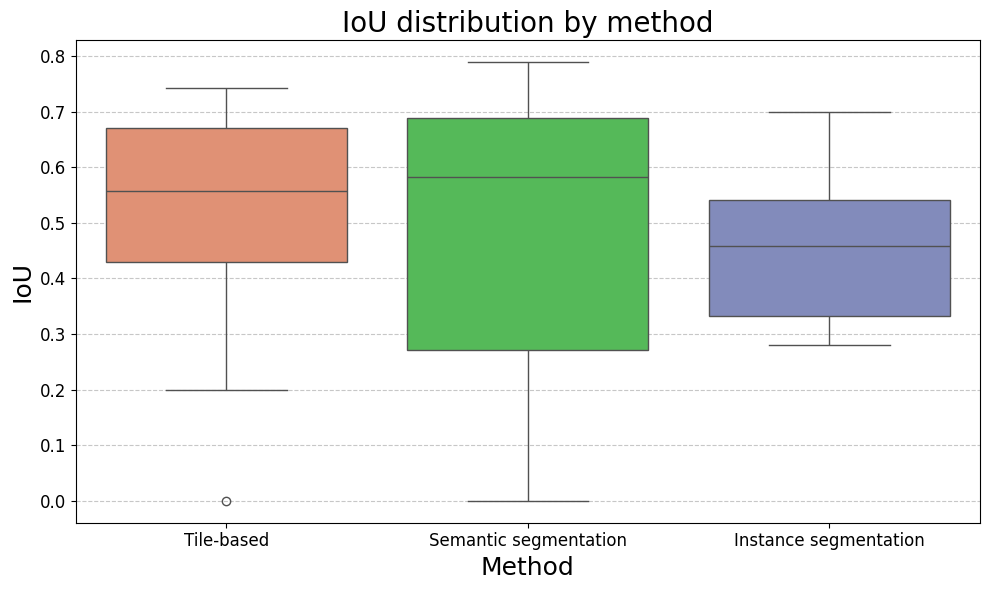

/tmp/ipykernel_2737291/2751031604.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='method', y='inference_time', estimator='mean', errorbar=('ci', 95), palette=color_list)


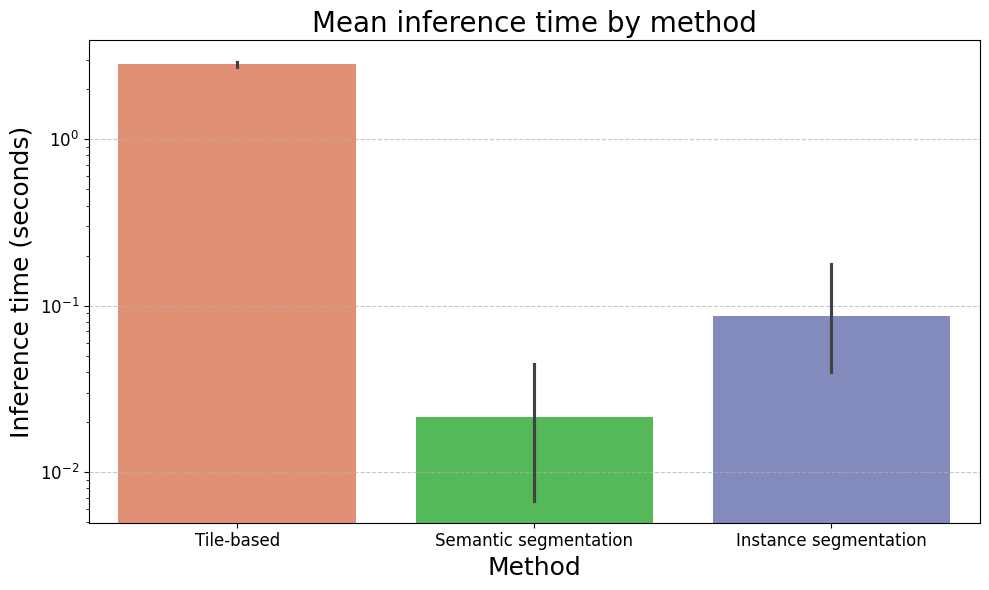

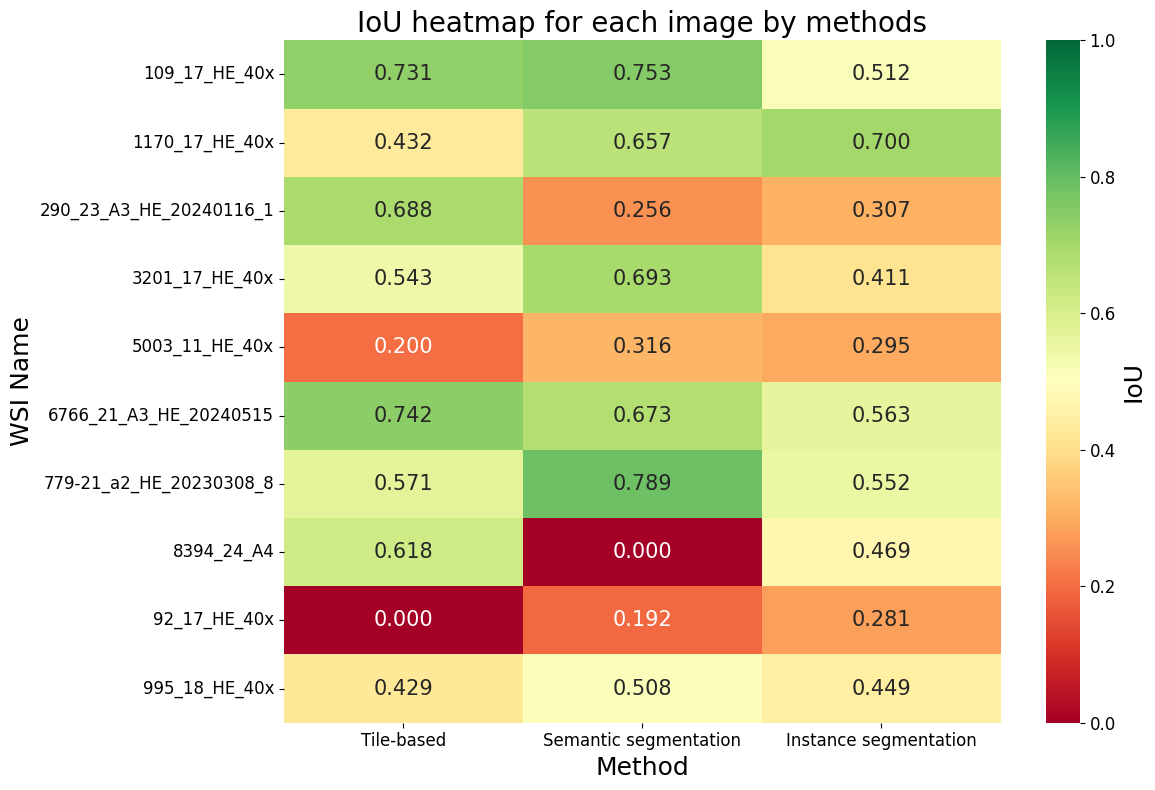

In [91]:
# PLOTS

# Define font sizes
TITLE_SIZE = 20
AXIS_LABEL_SIZE = 18
TICK_LABEL_SIZE = 12
LEGEND_SIZE = 15
ANNOTATION_SIZE = 15

#defining colors for each method for plots
method_colors = {
    "Tile-based": "#F28963",          
    "Semantic segmentation": "#44CA49",
    "Instance segmentation": "#7884C4"
}
color_list = [method_colors[method] for method in print_order]


# Box plot of IoU by method
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='method', y='iou', palette=color_list)
plt.title('IoU distribution by method', fontsize=TITLE_SIZE)
plt.ylabel('IoU', fontsize=AXIS_LABEL_SIZE)
plt.xlabel('Method', fontsize=AXIS_LABEL_SIZE)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=TICK_LABEL_SIZE)
plt.yticks(fontsize=TICK_LABEL_SIZE)
plt.tight_layout()

plt.savefig('results/figures/iou_boxplot.png', dpi=300)
plt.show()

# Bar plot of mean inference times
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='method', y='inference_time', estimator='mean', errorbar=('ci', 95), palette=color_list)
plt.title('Mean inference time by method', fontsize=TITLE_SIZE)
plt.ylabel('Inference time (seconds)', fontsize=AXIS_LABEL_SIZE)
plt.yscale('log')
plt.xlabel('Method', fontsize=AXIS_LABEL_SIZE)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=TICK_LABEL_SIZE)
plt.yticks(fontsize=TICK_LABEL_SIZE)
plt.tight_layout()

plt.savefig('results/figures/inference_time_barplot.png', dpi=300)
plt.show()

# IoU heatmap
pivot_iou = results_df.pivot_table(index='wsi_name', columns='method', values='iou', observed=False)
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_iou, 
    annot=True, 
    cmap="RdYlGn", 
    fmt='.3f', 
    cbar_kws={'label': 'IoU'}, 
    vmin=0, 
    vmax=1,
    annot_kws={"size": ANNOTATION_SIZE}
)
plt.title('IoU heatmap for each image by methods', fontsize=TITLE_SIZE)
plt.xlabel('Method', fontsize=AXIS_LABEL_SIZE)
plt.ylabel('WSI Name', fontsize=AXIS_LABEL_SIZE)
plt.xticks(fontsize=TICK_LABEL_SIZE)
plt.yticks(fontsize=TICK_LABEL_SIZE)
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=TICK_LABEL_SIZE)
cbar.set_label('IoU', fontsize=AXIS_LABEL_SIZE)
plt.tight_layout()

plt.savefig('results/figures/iou_heatmap.png', dpi=300)
plt.show()

## Image visualization

Visualizing 5003_11_HE_40x...
[(556288, 588800), (278144, 294400), (139072, 147200), (69536, 73600), (34768, 36800), (17384, 18400), (8692, 9200), (4346, 4600), (2173, 2300), (1086, 1150)]
torch.Size([3, 1024, 768])
Tile-based torch.Size([5888, 8192])
Semantic segmentation torch.Size([5888, 8192])
Instance segmentation torch.Size([5888, 8192])


IndexError: boolean index did not match indexed array along axis 0; size of axis is 1024 but size of corresponding boolean axis is 5888

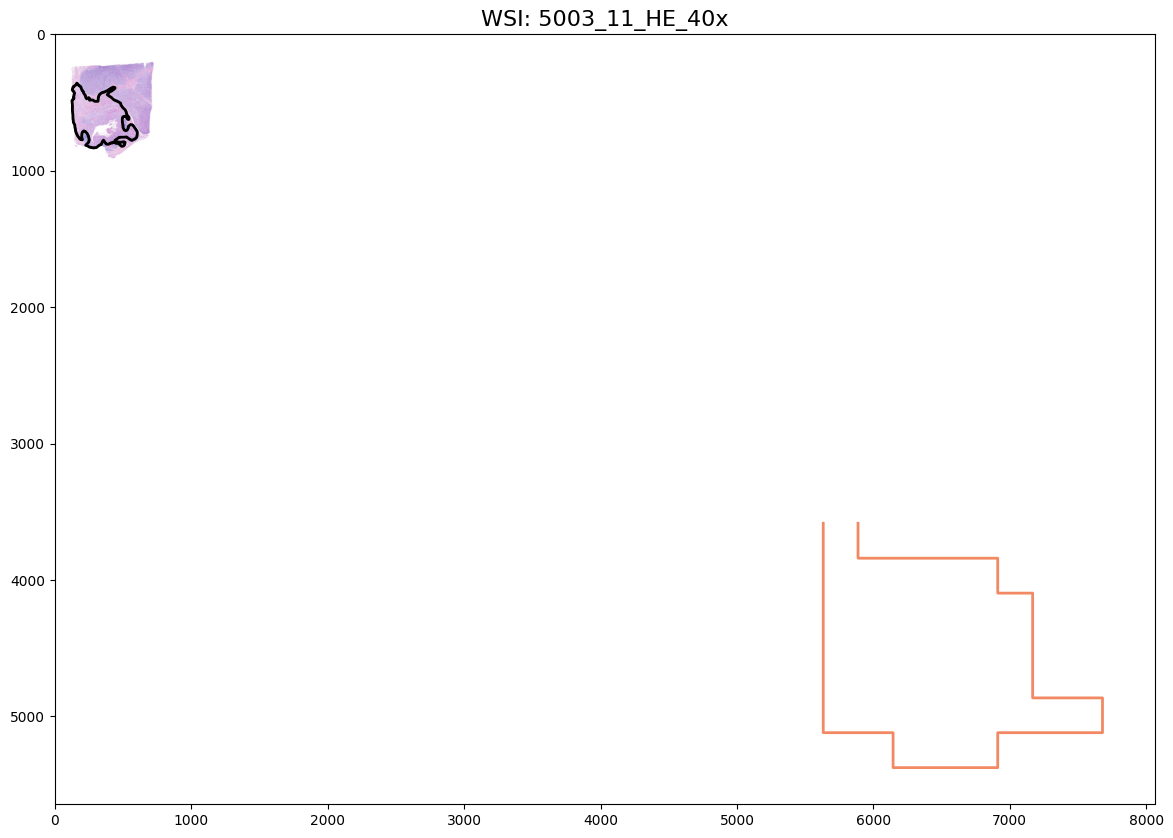

In [156]:
# Get unique WSI names
unique_wsi_names = set(results_df['wsi_name'])

# Create a figure directory if it doesn't exist
figures_dir = Path("results/images/")
figures_dir.mkdir(exist_ok=True, parents=True)

wsi_path = Path("/storage01/bolma/dev/data/BIOMAG_slides/Lung")

# Visualize each WSI
for wsi_name in unique_wsi_names:
    print(f"Visualizing {wsi_name}...")
    visualize_masks(wsi_name=wsi_name, 
                    matched_results=matched_results, 
                    wsi_folder=wsi_path, 
                    wsi_name_index_map=index_to_wsi_map,
                    slide_dataset=slide_dataset)